# COMP4660/8420 Lab 1.3 - Building a NN in PyTorch using custom Modules

While the nn package is useful for quickly building up a neural network, the real power comes when you can specify models that are more complex than a sequence of existing Modules. In order words, you can perform in-depth customization on your neural networks, such as adding multiple hidden layers of neurons, changing the activation functions or changing the learning algorithm. As you will be expected to write your own code for assignments, we will now introduce you to building a neural network with customised nn modules. 

The python script is an alternative implementation of Task1, but it demonstrates a way to define your own neural network by subclassing nn.Module and defining a forward function which receives input Variables and produces output Variables.  
______

## Step 0: Download and import all required libraries

To run this notebook, you need to have the following packages installed:
-  torch: a python deep learning package
-  pandas: a python data analysis package; if you are familiar with numpy, you can use numpy instead
-  matplotlib: a python package for data visualization

To install pytorch, please follow the __[instructions on their website](http://pytorch.org/)__. Please ensure you install version 0.4 or above.

To install pandas, in your terminal, type `pip3 install pandas` for python 3.

To install matplotlib, in your terminal, type `pip install matplotlib` for python 3.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Step 1: Load and setup training dataset

The dataset is separated into two files from original dataset:
-  iris_train.csv = dataset for training purpose, 80% from the original data
-  iris_test.csv  = dataset for testing purpose, 20% from the original data

In [2]:
# load training data
data_train = pd.read_csv('dataset/iris_train.csv')

# convert string target values to numeric values
#       class 0: Iris-setosa
#       class 1: Iris-versicolor
#       class 2: Iris-virginica
data_train.at[data_train['species'] == 'Iris-setosa', ['species']] = 0
data_train.at[data_train['species'] == 'Iris-versicolor', ['species']] = 1
data_train.at[data_train['species'] == 'Iris-virginica', ['species']] = 2

# Also convert all string numeric values to int ['2' -> 2]
data_train = data_train.apply(pd.to_numeric)

In [3]:
# The dataset is the same as the Task1, hence the visualization code has been
# commented out. To use it, simply uncomment it. 
# (Highlight code, and use Ctrl + /, to toggle multiline comment)

# print(data_train)

# # extract frequency of each species class
# class_freq = data_train['species'].value_counts()
# class_freq = list(class_freq.sort_index())

# # x-axis labels and length
# x_axis = list(range(0,3))

# graph = plt.bar(x_axis, class_freq)
# plt.xticks(x_axis)
# plt.ylabel('Frequency')
# plt.xlabel('Species')
# plt.title('Training Data')

# plt.show()

In [4]:
# convert pandas dataframe to array
# the first 4 columns are features
# the last column is target
data_train_array = data_train.values

# split x (features) and y (targets)
x_array = data_train_array[:, :4]
y_array = data_train_array[:, 4]

# create Tensors to hold inputs and outputs. Tensors are data structures
# similar to numpy matrices. They can be operated on efficiently by a GPU
# 
# Note: In torch versions before 0.4, Tensors had to be wrapped in a Variable
# to be used by the NN.
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)

## Step 2: Define and train a neural network

Here we build a neural network with one hidden layer.
-  input layer: 4 neurons, representing the features of Iris
-  hidden layer: 10 neurons, using Sigmoid as activation function
-  output layer: 3 neurons, representing the classes of Iris
    
The network will be trained with Stochastic Gradient Descent (SGD) as an 
optimiser, that will hold the current state and will update the parameters
based on the computed gradients.

Its performance will be evaluated using cross-entropy.
    
We implement the same neural network as before using a custom Module subclass.

In [5]:
# define the number of neurons for input layer, hidden layer and output layer
# define learning rate and number of epoch on training
# Note the more generalizable ways of defining number of input and output neurons

input_neurons = x_array.shape[1]
hidden_neurons = 10
output_neurons = np.unique(y_array).size
learning_rate = 0.01
num_epoch = 500

In [6]:
# define a customised neural network structure
class TwoLayerNet(torch.nn.Module):

    def __init__(self, n_input, n_hidden, n_output):
        super(TwoLayerNet, self).__init__()
        # define linear hidden layer output
        self.hidden = torch.nn.Linear(n_input, n_hidden)
        # define linear output layer output
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        """
            In the forward function we define the process of performing
            forward pass, that is to accept a Variable of input
            data, x, and return a Variable of output data, y_pred.
        """
        # get hidden layer input
        h_input = self.hidden(x)
        # define activation function for hidden layer
        h_output = torch.sigmoid(h_input)
        # get output layer output
        y_pred = self.out(h_output)

        return y_pred

In [7]:
# define a neural network using the customised structure
net = TwoLayerNet(input_neurons, hidden_neurons, output_neurons)

# define loss function
loss_func = torch.nn.CrossEntropyLoss()

# define optimiser
optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [8]:
# store all losses for visualisation
all_losses = []

# train a neural network
for epoch in range(num_epoch):
    # Perform forward pass: compute predicted y by passing x to the model.
    # Here we pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    # In this case, Y_pred contains three columns, where the index of the
    # max column indicates the class of the instance
    Y_pred = net(X)

    # Compute loss
    # Here we pass Tensors containing the predicted and true values of Y,
    # and the loss function returns a Tensor containing the loss.
    loss = loss_func(Y_pred, Y)
    all_losses.append(loss.item())

    # print progress
    if (epoch + 1) % 50 == 0:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(F.softmax(Y_pred,1), 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()

        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

    # Clear the gradients before running the backward pass.
    net.zero_grad()

    # Perform backward pass: compute gradients of the loss with respect to
    # all the learnable parameters of the model.
    loss.backward()

    # Calling the step function on an Optimiser makes an update to its
    # parameters
    optimiser.step()

Epoch [50/500] Loss: 1.0729  Accuracy: 36.67 %
Epoch [100/500] Loss: 1.0548  Accuracy: 36.67 %
Epoch [150/500] Loss: 1.0385  Accuracy: 36.67 %
Epoch [200/500] Loss: 1.0212  Accuracy: 36.67 %
Epoch [250/500] Loss: 1.0019  Accuracy: 41.67 %
Epoch [300/500] Loss: 0.9803  Accuracy: 60.00 %
Epoch [350/500] Loss: 0.9570  Accuracy: 70.00 %
Epoch [400/500] Loss: 0.9325  Accuracy: 74.17 %
Epoch [450/500] Loss: 0.9071  Accuracy: 80.00 %
Epoch [500/500] Loss: 0.8812  Accuracy: 85.83 %


Plot historical loss from `all_losses` during network learning.

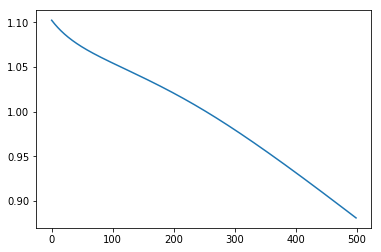

In [9]:
plt.figure()
plt.plot(all_losses)
plt.show()

#### Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every iris flower (rows)
which class the network guesses (columns). 


In [10]:
confusion = torch.zeros(output_neurons, output_neurons)

Y_pred = net(X)
_, predicted = torch.max(F.softmax(Y_pred,1), 1)

for i in range(x_array.shape[0]):
    actual_class = Y.data[i]
    predicted_class = predicted.data[i]

    confusion[actual_class][predicted_class] += 1

print('')
print('Confusion matrix for training:')
print(confusion.numpy())


Confusion matrix for training:
[[37.  0.  0.]
 [ 0. 44.  0.]
 [ 0. 17. 22.]]


## Step 3: Load and setup testing dataset

The dataset is separated into two files from original dataset:
-  iris_train.csv = dataset for training purpose, 80% from the original data
-  iris_test.csv  = dataset for testing purpose, 20% from the original data

In [11]:
# load testing data
data_test = pd.read_csv('dataset/iris_test.csv')

# convert string target values to numeric values
#       class 0: Iris-setosa
#       class 1: Iris-versicolor
#       class 2: Iris-virginica
data_test.at[data_test['species'] == 'Iris-setosa', ['species']] = 0
data_test.at[data_test['species'] == 'Iris-versicolor', ['species']] = 1
data_test.at[data_test['species'] == 'Iris-virginica', ['species']] = 2

# Also convert all string numeric values to int ['2' -> 2]
data_test = data_test.apply(pd.to_numeric)

In [12]:
# convert pandas dataframe to array
# the first 4 columns are features
# the last column is target
data_test_array = data_test.values

# split x (features) and y (targets)
x_test_array = data_test_array[:, :4]
y_test_array = data_test_array[:, 4]

# create Tensors to hold inputs and outputs
X_test = torch.tensor(x_test_array, dtype=torch.float)
Y_test = torch.tensor(y_test_array, dtype=torch.long)

## Step 4: Test the neural network

Pass testing data to the built neural network and get its performance

In [13]:
# test the neural network using testing data
# It is actually performing a forward pass computation of predicted y
# by passing x to the model.
# Here, Y_pred_test contains three columns, where the index of the
# max column indicates the class of the instance
Y_pred_test = net(X_test)

# get prediction
# convert three-column predicted Y values to one column for comparison
_, predicted_test = torch.max(F.softmax(Y_pred_test,1), 1)

# calculate accuracy
total_test = predicted_test.size(0)
correct_test = sum(predicted_test.data.numpy() == Y_test.data.numpy())

print('Testing Accuracy: %.2f %%' % (100 * correct_test / total_test))

Testing Accuracy: 80.00 %


#### Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every iris flower (rows)
which class the network guesses (columns). 

In [14]:
confusion_test = torch.zeros(output_neurons, output_neurons)

for i in range(x_test_array.shape[0]):
    actual_class = Y_test.data[i]
    predicted_class = predicted_test.data[i]

    confusion_test[actual_class][predicted_class] += 1

print('')
print('Confusion matrix for testing:')
print(confusion_test.numpy())


Confusion matrix for testing:
[[13.  0.  0.]
 [ 0.  6.  0.]
 [ 0.  6.  5.]]


_**Q1. What is the classification accuracy?**_

_**Q2. Try running the network with different number of hidden neurons. What effect does it have on the accuracy?**_

_**Q3. What was the best accuracy you were able to achieve? What were the parameters of the neural network?**_

_**Q4. Run the neural network again using the same parameters as your best result. Did you receive the exact same result again? Why might it different?**_

_**Q5. If you have finished the other tasks, try extending the functionality of the neural network and playing around with the parameters, such as the number of hidden neurons and the number of hidden layers. You can try changing the activation functions to others to see what effect this has on the output and error. You can also look into the other types of neural networks and learning algorithms that PyTorch has available.**_